<a href="https://colab.research.google.com/github/ayulockin/deepimageinpainting/blob/master/Image_Inpainting_Autoencoder_Decoder_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando TensorFlow e checando se a GPU responde a ele

In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

print('[INFO]', tf.config.experimental.list_physical_devices('GPU')[0])

2.10.1
[INFO] PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid


In [3]:
# Definir diretórios base
base_dir = 'C:/Users/mathe/Desktop/facul/database-tcc/ImageNet1k'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [4]:
# Pegar os diretórios das imagens de treino, teste e validação e separar em batches de 32, e redimensionalizar as imagens para 256x256
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(256, 256), batch_size=10, class_mode=None)
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(256, 256), batch_size=10, class_mode=None)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(256, 256), batch_size=10, class_mode=None)

Found 700 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [5]:
# Verificar se as imagens estão no tamanho correto
assert train_generator.image_shape == val_generator.image_shape == test_generator.image_shape == (256, 256, 3) , 'Imagens não estão no tamanho correto'

(10, 256, 256, 3)


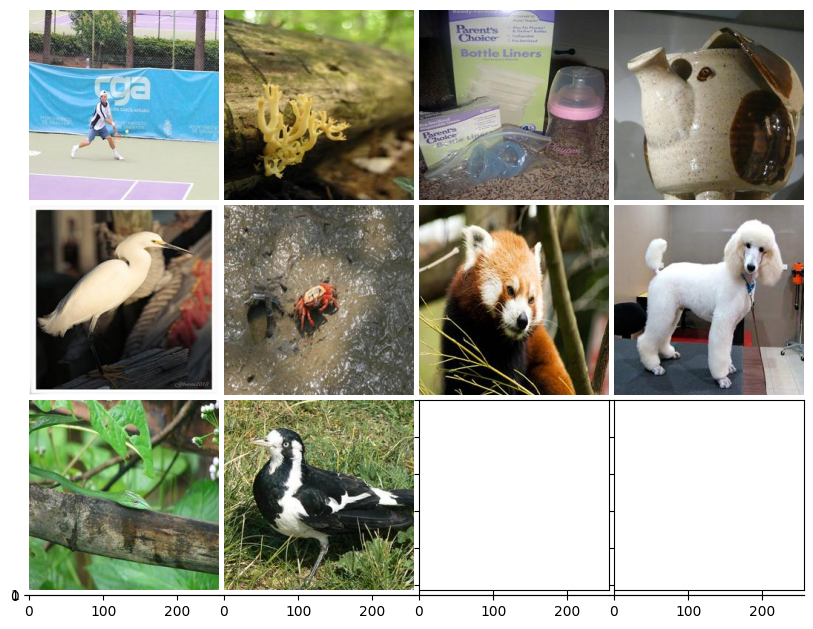

In [6]:
# Dá exemplo de imagens, para vermos se está tudo correto
batch = next(train_generator)
print(batch.shape)

# Plotar imagens
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
for ax, img in zip(grid, batch):
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [7]:
# Vamos agora utilizar essa imagens para treinar um modelo de inpainting, que vai tentar prever o buraco da imagem
# Para isso precisamos que além dessas imagens, tenhamos uma versão delas com buracos desenhados, para que o modelo 
# possa aprender a preencher esses buracos

# Vamos criar uma função que vai pegar uma imagem e desenhar um buraco nela, mas deve ser um buraco de formato e tamanho aleatório
# podendo ser até mais de um buraco, linha, curva ou qualquer outra coisa. Podemos usar funções do OpenCV para isso.

# Função para desenhar um buraco na imagem e retornar a imagem original com uma mascara preta.

import random

def random_mask(img, max_shapes=5):
    """
    Aplica uma máscara aleatória à imagem.
    
    Parâmetros:
    - img: imagem de entrada de tamanho 256x256x3
    - max_shapes: número máximo de formas aleatórias na máscara
    
    Retorna:
    - Imagem com regiões aleatórias faltantes
    """
    h, w, _ = img.shape
    mask = np.ones((h, w), np.uint8) * 255

    for _ in range(random.randint(1, max_shapes)):
        # Escolha aleatoriamente entre criar um polígono, linha ou curva
        shape_type = random.choice(['polygon', 'line', 'curve'])

        if shape_type == 'polygon':
            # Crie um polígono irregular
            vertices = np.array([[
                (random.randint(0, w), random.randint(0, h)) for _ in range(random.randint(3, 10))
            ]], dtype=np.int32)
            cv2.fillPoly(mask, vertices, 0)

        elif shape_type == 'line':
            # Crie uma linha aleatória
            pt1 = (random.randint(0, w), random.randint(0, h))
            pt2 = (random.randint(0, w), random.randint(0, h))
            cv2.line(mask, pt1, pt2, 0, thickness=random.randint(1, 5))

        elif shape_type == 'curve':
            # Crie uma curva (usando polígonos com poucos vértices)
            vertices = np.array([[
                (random.randint(0, w), random.randint(0, h)) for _ in range(random.randint(2, 4))
            ]], dtype=np.int32)
            cv2.polylines(mask, vertices, isClosed=False, color=0, thickness=random.randint(1, 5))

    # Aplica a máscara à imagem
    masked_img = cv2.bitwise_and(img, img, mask=mask)

    return masked_img


In [8]:
# uma versao mais simples só para desenhar linhas


def random_mask2(img, max_lines=5):
    """
    Aplica linhas aleatórias como máscara à imagem.
    
    Parâmetros:
    - img: imagem de entrada de tamanho 256x256x3
    - max_lines: número máximo de linhas aleatórias na máscara
    
    Retorna:
    - Imagem com linhas aleatórias faltantes
    """
    h, w, _ = img.shape
    mask = np.ones((h, w), np.uint8) * 255

    for _ in range(random.randint(4, max_lines)):
        # Crie uma linha aleatória
        pt1 = (random.randint(0, w), random.randint(0, h))
        pt2 = (random.randint(0, w), random.randint(0, h))
        cv2.line(mask, pt1, pt2, 0, thickness=random.randint(1, 5))

    # Aplica a máscara à imagem
    masked_img = cv2.bitwise_and(img, img, mask=mask)

    return masked_img

In [9]:
import cv2
import numpy as np
import random

def bezier_curve(points, num=1000):
    """
    Retorna uma curva bezier a partir de pontos de controle.
    """
    t_values = np.linspace(0, 1, num)
    curve = []
    N = len(points) - 1

    for t in t_values:
        x_val = sum([comb(N, i) * (1 - t) ** (N - i) * t ** i * point[0] for i, point in enumerate(points)])
        y_val = sum([comb(N, i) * (1 - t) ** (N - i) * t ** i * point[1] for i, point in enumerate(points)])
        curve.append((x_val, y_val))
    
    return curve


def random_mask3(img, max_lines=5, max_curves=3):
    """
    Aplica linhas e curvas aleatórias como máscara à imagem.
    """
    h, w, _ = img.shape
    mask = np.ones((h, w), np.uint8) * 255

    # Desenhar linhas aleatórias
    for _ in range(random.randint(1, max_lines)):
        pt1 = (random.randint(0, w), random.randint(0, h))
        pt2 = (random.randint(0, w), random.randint(0, h))
        cv2.line(mask, pt1, pt2, 0, thickness=random.randint(1, 5))

    # Desenhar curvas aleatórias
    for _ in range(random.randint(1, max_curves)):
        num_points = random.randint(3, 4)  # 3 ou 4 pontos de controle
        points = [(random.randint(0, w), random.randint(0, h)) for _ in range(num_points)]
        curve = bezier_curve(points)
        for i in range(1, len(curve)):
            cv2.line(mask, (int(curve[i-1][0]), int(curve[i-1][1])), (int(curve[i][0]), int(curve[i][1])), 0, thickness=random.randint(1, 3))

    # Aplica a máscara à imagem
    masked_img = cv2.bitwise_and(img, img, mask=mask)

    return masked_img

# Função auxiliar para calcular combinações (usada na curva bezier)
def comb(n, k):
    from math import factorial
    return factorial(n) / (factorial(k) * factorial(n - k))


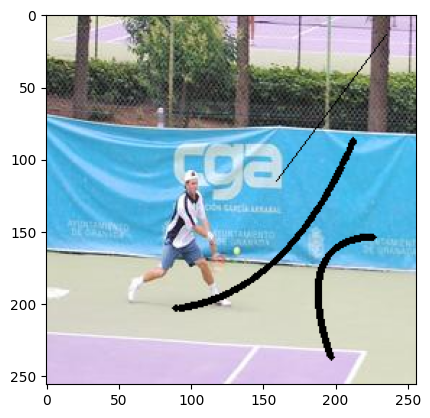

In [10]:
# testa a funcao
img = batch[0]
masked_img = random_mask3(img)
plt.imshow(masked_img)

In [11]:
# Queria criar uma classe createAugmentation agora que usasse a funcao de criação de mascaras para em tempo real criar as imagens
# com buracos. 

# Vamos criar uma classe que vai pegar as imagens do gerador e aplicar a função de criação de buracos nelas, para que possamos
# treinar o modelo com as imagens com buracos.

## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

## Seguindo a referência acima, criamos uma classe para gerar os dados de treino e teste, é um gerador de dados que além de tudo 
## aplica uma máscara aleatória nas imagens de treino, para que a rede aprenda a reconstruir a imagem original a partir da máscara.

class createAugment(keras.utils.Sequence):
    """
    Classe dedicada para data Augmentation, em especial para o problema de inpainting, criando máscaras.
    """
    def __init__(self, generator, batch_size=32, dim=(256, 256), n_channels=3, shuffle=True):
        self.generator = generator
        self.batch_size = batch_size 
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        
        self.on_epoch_end() # Inicializa os índices assim que o objeto é criado

    def on_epoch_end(self) -> None:
        """
        Inicializa ou re-inicializa os indexes após cada época, de preferencia com shuffle = True para o modelo desempenhar de forma robusta.
        """
        self.indexes = np.arange(len(self.generator))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self) -> int:
        """
        Retorna o número de batches por época
        """
        return len(self.generator)

    def __getitem__(self, index) -> tuple:  
        """
        É passado um batch de índices para o gerador de dados, que retorna um batch de dados gerados a partir dos índices passados.
        """
        X_batch_original = self.generator[index]
        return self.__data_generation(X_batch_original)

    def __data_generation(self, X_batch_original) -> tuple:
        """ 
        Função que gera um batch de dados para treinamento a partir de um batch de índices. Os dados retornados são um batch de imagens
        mascaradas e um batch de imagens originais, para que o erro seja calculado a partir da imagem reconstruída.
        """
        X_batch = np.array([random_mask3(img) for img in X_batch_original])
        return X_batch, X_batch_original


In [12]:
# Defina sua função random_mask aqui ou importe-a se estiver em outro arquivo

# Instancie sua classe de augmentation
augmented_train_generator = createAugment(train_generator, batch_size=10, dim=(256, 256), n_channels=3, shuffle=True)

# Número de batches a serem testados
num_batches = 10

for i in range(num_batches):
    X_batch, y_batch = augmented_train_generator[i]
    
    for j in range(len(X_batch)):
        diff = np.abs(X_batch[j] - y_batch[j])
        total_diff = np.sum(diff)
        
        if total_diff == 0:
            print(f"Erro: A imagem {j} no batch {i} não foi mascarada!")
        else:
            # Reescala as imagens para o intervalo [0, 255] antes de visualizar
            visual_masked = (X_batch[j] * 255).astype(np.uint8)
            visual_original = (y_batch[j] * 255).astype(np.uint8)

"""         
            # Visualizar a imagem mascarada e a imagem original
            cv2.imshow(f"Masked Image {j}", visual_masked)
            cv2.imshow(f"Original Image {j}", visual_original)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
"""
# dei Keyboard interrupt mas testado e funcionando!!!! 

'         \n            # Visualizar a imagem mascarada e a imagem original\n            cv2.imshow(f"Masked Image {j}", visual_masked)\n            cv2.imshow(f"Original Image {j}", visual_original)\n            cv2.waitKey(0)\n            cv2.destroyAllWindows()\n'

## Autoencoder-Decoder Model

In [13]:
# Vídeo sobre a métrica do coeficiente de dice que vamos usar: https://www.youtube.com/watch?v=AZr64OxshLo

# Essa métrica é basicamente uma medida de o quanto essa imagem se parece com a original, ou seja, o quanto a imagem reconstruída
# se parece com a imagem original.
# Quanto mais próximo de 1, melhor, essa métrica será usada para o gerador.

def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [14]:
class GeneratorModel:
  '''
  Fazendo uma UNET para o problema de inpainting. 
  '''
  def prepare_model(self, input_size=(256,256,3)):
    inputs = keras.layers.Input(input_size)

    conv0, pool0 = self.__ConvBlock(16, (3,3), (2,2), 'relu', 'same', inputs)  
    conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', pool0) 
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    conv9, up10 = self.__UpConvBlock(32, 16, (3,3), (2,2), (2,2), 'relu', 'same', up9, conv0)  
    
    conv10 = self.__ConvBlock(16, (3,3), (2,2), 'relu', 'same', up10, False)  
    
    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv10)

    return keras.models.Model(inputs=[inputs], outputs=[outputs]) 

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

In [15]:
def build_discriminator(input_shape):
    model = keras.models.Sequential()
    
    model.add(keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(keras.layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(keras.layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    return model

In [16]:
def gan_model(generator, discriminator, input_shape=(256,256,3)):
    discriminator.trainable = False  # Congele os pesos do discriminador durante o treinamento da GAN
    
    inputs = keras.layers.Input(input_shape)
    generated_image = generator(inputs)
    validity = discriminator(generated_image)
    
    gan = keras.models.Model(inputs, validity)
    return gan

In [17]:
# Instânciando os modelos

# Gerador
keras.backend.clear_session()
generator = GeneratorModel().prepare_model()
generator.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef]) 

# Discriminador
discriminator = build_discriminator((256,256,3))
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# GAN
gan = gan_model(generator=generator, discriminator=discriminator) 
gan.compile(optimizer='adam', loss='binary_crossentropy')

In [18]:
# Criando callback para salvar os pesos do modelo no melhor ponto de validação e para parar o treinamento caso o modelo não melhore.

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, monitor='val_loss', mode='min')


In [19]:
# para arrumar bug de callback
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


# Train

In [20]:
batch_size = 10
epochs = 20

tf.keras.backend.clear_session()

for epoch in range(epochs):
    print(f"Epoch {epoch}/{epochs}")
    
    for index in range(len(augmented_train_generator)):
        # ---------------------
        #  Treine o Discriminador
        # ---------------------
        
        # Obtenha um batch de imagens do gerador
        masked_images, real_images = augmented_train_generator[index]
        
        generated_images = generator.predict(masked_images)
        
        batch_size_actual = real_images.shape[0]  # Obtenha o tamanho real do batch
        real_labels = np.ones((batch_size_actual, 1))
        fake_labels = np.zeros((batch_size_actual, 1))

        
        # Treine o Discriminador
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # ---------------------
        #  Treine o Gerador
        # ---------------------
        
        labels_gan = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(masked_images, labels_gan)
        
        #print(f"Batch {index}/{len(augmented_train_generator)} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss}]")
    
    # Se você quiser salvar os pesos a cada época (ou a cada N épocas), você pode fazer:
    if epoch % 10 == 0:  # Salva os pesos a cada 10 épocas, por exemplo
        gan.save_weights('gan_weights_epoch_{}.h5'.format(epoch))


Epoch 0/20


c:\Users\mathe\miniconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 0s 57ms/step
Epoch 1/20
1/1 [==============================] - 0s 55ms/step
Epoch 2/20
1/1 [==============================] - 0s 52ms/step
Epoch 3/20
1/1 [==============================] - 0s 55ms/step
Epoch 4/20
1/1 [==============================] - 0s 53ms/step
Epoch 5/20
1/1 [==============================] - 0s 62ms/step
Epoch 6/20
1/1 [==============================] - 0s 53ms/step
Epoch 7/20
1/1 [==============================] - 0s 52ms/step
Epoch 8/20
1/1 [==============================] - 0s 53ms/step
Epoch 9/20
1/1 [==============================] - 0s 52ms/step
Epoch 10/20
1/1 [==============================] - 0s 53ms/step
Epoch 11/20
1/1 [==============================] - 0s 54ms/step
Epoch 12/20
1/1 [==============================] - 0s 52ms/step
Epoch 13/20
1/1 [==============================] - 0s 51ms/step
Epoch 14/20
1/1 [==============================] - 0s 54ms/step
Epoch 15/20
1/1 [==============================] - 0s 77ms/st

1/1 [==============================] - 0s 77ms/step


c:\Users\mathe\miniconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


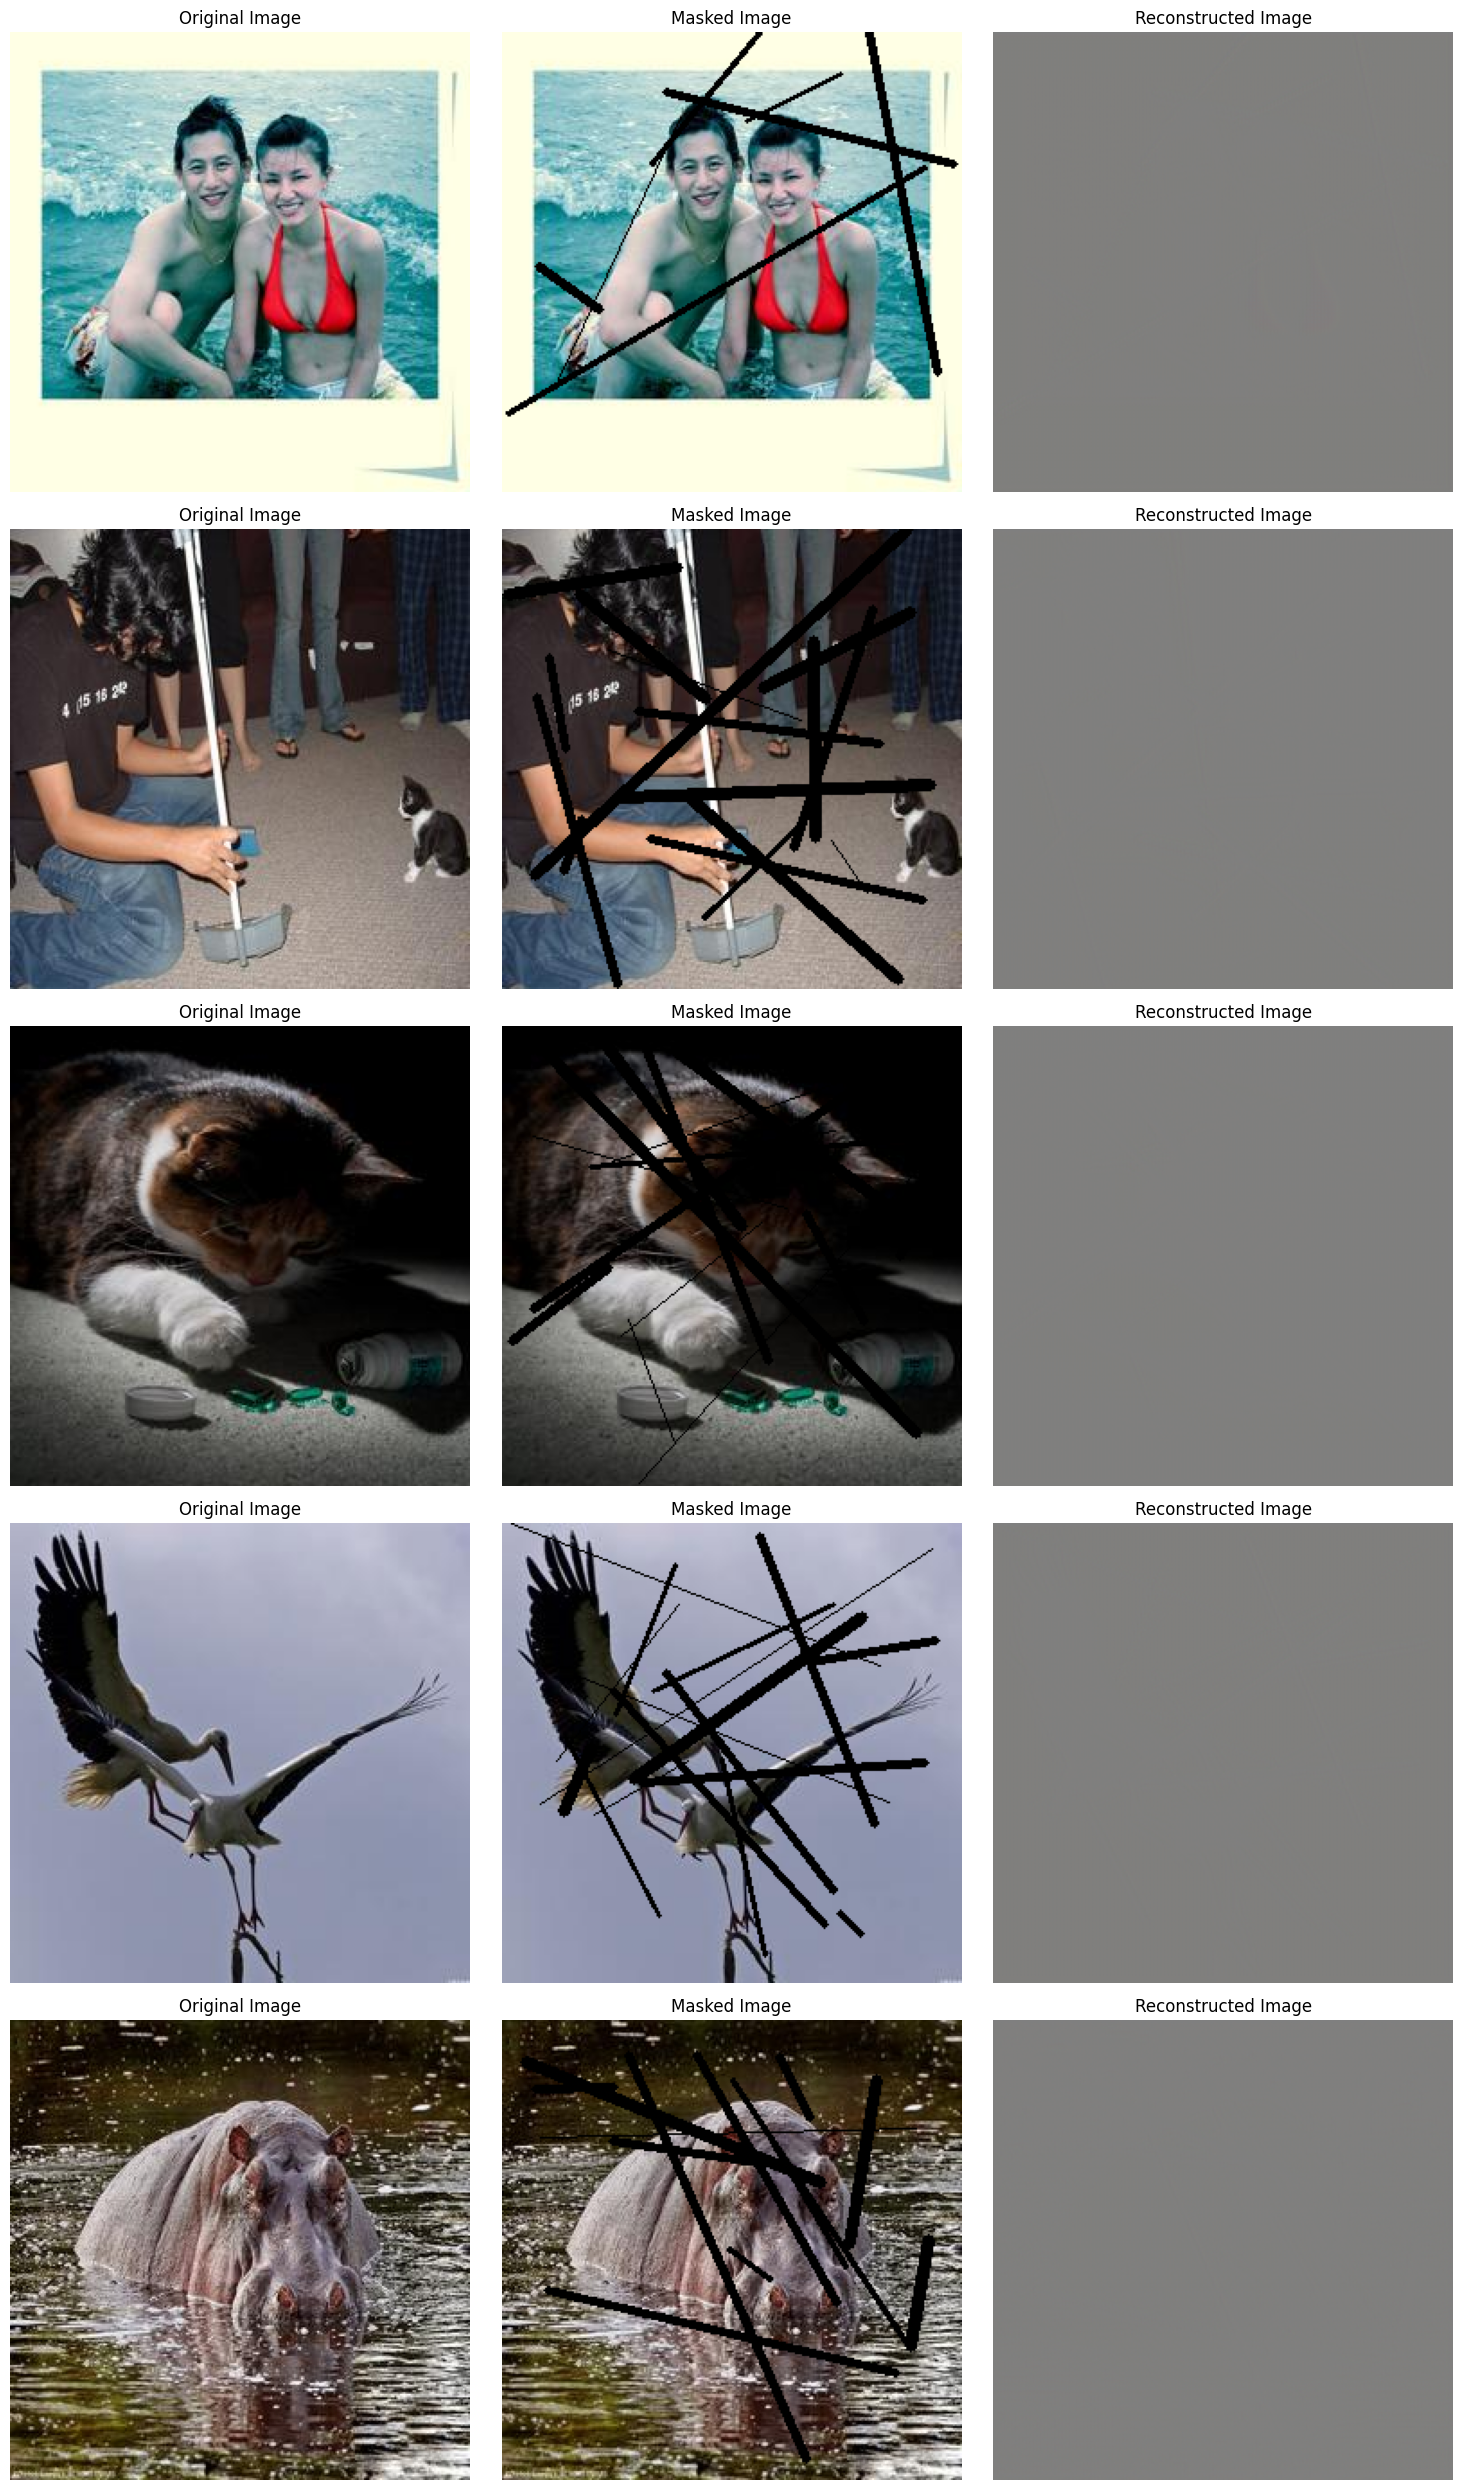

In [26]:
import matplotlib.pyplot as plt

def plot_results(model, test_generator, num_samples=5):
    """
    Plota imagens originais, imagens mascaradas e imagens reconstruídas.
    
    Parâmetros:
    - model: Modelo treinado.
    - test_generator: Gerador de dados de teste.
    - num_samples: Número de amostras a serem plotadas.
    """
    
    # Pegar um batch de imagens do test_generator
    X_batch = test_generator.next()
    
    # Criar máscaras para as imagens
    X_masked = np.array([random_mask2(img, 20) for img in X_batch])
    
    # Usar o modelo para prever as imagens reconstruídas
    X_pred = model.predict(X_masked)
    
    # Plotar as imagens
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        axes[i, 0].imshow(X_batch[i])
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(X_masked[i])
        axes[i, 1].set_title("Masked Image")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(X_pred[i])
        axes[i, 2].set_title("Reconstructed Image")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Chamar a função 
plot_results(generator, test_generator)


In [27]:
# wtf pq ta cinza essa merda